#### Import All the Required Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from skimage import filters, morphology, exposure, feature, segmentation
from skimage.util import random_noise
import glob
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from datetime import datetime

# Set up matplotlib for inline display
%matplotlib inline

# Set style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

#### Enhanced Configuration and Dataset Setup

In [ ]:
class Config:
    def __init__(self):
        self.dataset_path = "enhanced_dataset"
        self.output_path = "processed_images"
        self.analysis_path = "analysis_results"
        self.image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
        self.processing_params = {
            'gaussian_kernel': (5, 5),
            'canny_low': 50,
            'canny_high': 150,
            'clahe_clip_limit': 2.0,
            'morph_kernel_size': 3
        }
        
    def setup_directories(self):
        """Create necessary directories"""
        os.makedirs(self.output_path, exist_ok=True)
        os.makedirs(self.analysis_path, exist_ok=True)
        os.makedirs(os.path.join(self.output_path, "grayscale"), exist_ok=True)
        os.makedirs(os.path.join(self.output_path, "edges"), exist_ok=True)
        os.makedirs(os.path.join(self.output_path, "enhanced"), exist_ok=True)
        os.makedirs(os.path.join(self.output_path, "segmented"), exist_ok=True)

# Initialize configuration
config = Config()
config.setup_directories()

# Get all image files
image_files = []
for ext in config.image_extensions:
    image_files.extend(glob.glob(os.path.join(config.dataset_path, ext)))
image_files.sort()  # Sort for consistent processing

print(f"Found {len(image_files)} images in dataset")
print(f"First 5 images: {[os.path.basename(f) for f in image_files[:5]]}")

Found 397 images in dataset
First 5 images: ['10_basic_zoom_in_00.jpg', '10_blue_enhance_08.jpg', '10_blur_stretch_blue_14.jpg', '10_contrast_enhance_11.jpg', '10_contrast_stretch_13.jpg']


#### Advanced Image Processing Functions

In [ ]:
class ImageProcessor:
    def __init__(self, config):
        self.config = config
        
    def load_image(self, image_path):
        """Load image with error handling"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Could not load image: {image_path}")
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img_rgb
        except Exception as e:
            print(f"Error loading {image_path}: {str(e)}")
            return None
    
    def basic_preprocessing(self, img):
        """Apply basic preprocessing pipeline"""
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Gaussian blur for noise reduction
        blurred = cv2.GaussianBlur(gray, self.config.processing_params['gaussian_kernel'], 0)
        
        # Histogram equalization for contrast enhancement
        equalized = cv2.equalizeHist(blurred)
        
        return gray, blurred, equalized
    
    def advanced_processing(self, img):
        """Apply advanced image processing techniques"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Edge detection using Canny
        edges = cv2.Canny(gray, 
                         self.config.processing_params['canny_low'],
                         self.config.processing_params['canny_high'])
        
        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=self.config.processing_params['clahe_clip_limit'])
        clahe_img = clahe.apply(gray)
        
        # Morphological operations
        kernel = np.ones((self.config.processing_params['morph_kernel_size'], 
                         self.config.processing_params['morph_kernel_size']), np.uint8)
        morph_closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
        
        return edges, clahe_img, morph_closed
    
    def kmeans_segmentation(self, img, k=3):
        """Apply K-means clustering for image segmentation"""
        # Reshape image to 2D array of pixels
        pixel_values = img.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)
        
        # Apply K-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        
        # Convert back to 8-bit values
        centers = np.uint8(centers)
        
        # Flatten the labels array
        labels = labels.flatten()
        
        # Convert all pixels to the color of the centroids
        segmented_image = centers[labels]
        
        # Reshape back to original image dimension
        segmented_image = segmented_image.reshape(img.shape)
        
        return segmented_image

# Initialize processor
processor = ImageProcessor(config)

#### Enhanced Batch Processing with Multiple Techniques

In [ ]:
def process_all_images_enhanced(limit=None):
    """Process all images with multiple techniques and save results"""
    if limit:
        images_to_process = image_files[:limit]
    else:
        images_to_process = image_files
        
    print(f"Processing {len(images_to_process)} images with enhanced pipeline...")
    print("=" * 60)
    
    # Initialize results storage
    processing_results = []
    
    for i, image_path in enumerate(tqdm(images_to_process, desc="Processing Images")):
        try:
            filename = os.path.basename(image_path)
            print(f"\nProcessing {i+1}/{len(images_to_process)}: {filename}")
            
            # Load image
            img = processor.load_image(image_path)
            if img is None:
                continue
                
            # Apply basic preprocessing
            gray, blurred, equalized = processor.basic_preprocessing(img)
            
            # Apply advanced processing
            edges, clahe_img, morph_closed = processor.advanced_processing(img)
            
            # Apply K-means segmentation
            segmented = processor.kmeans_segmentation(img, k=3)
            
            # Save all processed versions
            base_name = os.path.splitext(filename)[0]
            
            # Save grayscale
            cv2.imwrite(os.path.join(config.output_path, "grayscale", f"gray_{base_name}.png"), gray)
            
            # Save edge detection
            cv2.imwrite(os.path.join(config.output_path, "edges", f"edges_{base_name}.png"), edges)
            
            # Save enhanced images
            cv2.imwrite(os.path.join(config.output_path, "enhanced", f"clahe_{base_name}.png"), clahe_img)
            
            # Save segmented images
            cv2.imwrite(os.path.join(config.output_path, "segmented", f"segmented_{base_name}.png"), 
                       cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
            
            # Store processing results
            result = {
                'filename': filename,
                'original_shape': img.shape,
                'grayscale_mean': np.mean(gray),
                'edges_density': np.sum(edges > 0) / edges.size,
                'processing_time': datetime.now()
            }
            processing_results.append(result)
            
            print(f"Successfully processed: {filename}")
            
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            continue
    
    # Save processing results to CSV
    if processing_results:
        results_df = pd.DataFrame(processing_results)
        results_df.to_csv(os.path.join(config.analysis_path, "processing_results.csv"), index=False)
        print(f"\nProcessing results saved to: {os.path.join(config.analysis_path, 'processing_results.csv')}")
    
    print(f"\nEnhanced processing completed! Processed {len(processing_results)} images successfully.")
    return processing_results

print("Testing pipeline with first 10 images...")
results = process_all_images_enhanced(limit=5)

Testing pipeline with first 10 images...
Processing 5 images with enhanced pipeline...


Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]


Processing 1/5: 10_basic_zoom_in_00.jpg


Processing Images:  20%|██        | 1/5 [00:59<03:56, 59.16s/it]

Successfully processed: 10_basic_zoom_in_00.jpg

Processing 2/5: 10_blue_enhance_08.jpg


Processing Images:  40%|████      | 2/5 [01:56<02:54, 58.11s/it]

Successfully processed: 10_blue_enhance_08.jpg

Processing 3/5: 10_blur_stretch_blue_14.jpg


Processing Images:  60%|██████    | 3/5 [02:54<01:56, 58.26s/it]

Successfully processed: 10_blur_stretch_blue_14.jpg

Processing 4/5: 10_contrast_enhance_11.jpg


Processing Images:  80%|████████  | 4/5 [03:44<00:54, 54.99s/it]

Successfully processed: 10_contrast_enhance_11.jpg

Processing 5/5: 10_contrast_stretch_13.jpg


Processing Images: 100%|██████████| 5/5 [04:39<00:00, 55.87s/it]

Successfully processed: 10_contrast_stretch_13.jpg

Processing results saved to: analysis_results\processing_results.csv

Enhanced processing completed! Processed 5 images successfully.


#### Visualization and Analysis Functions

Displaying processing results for first few images...


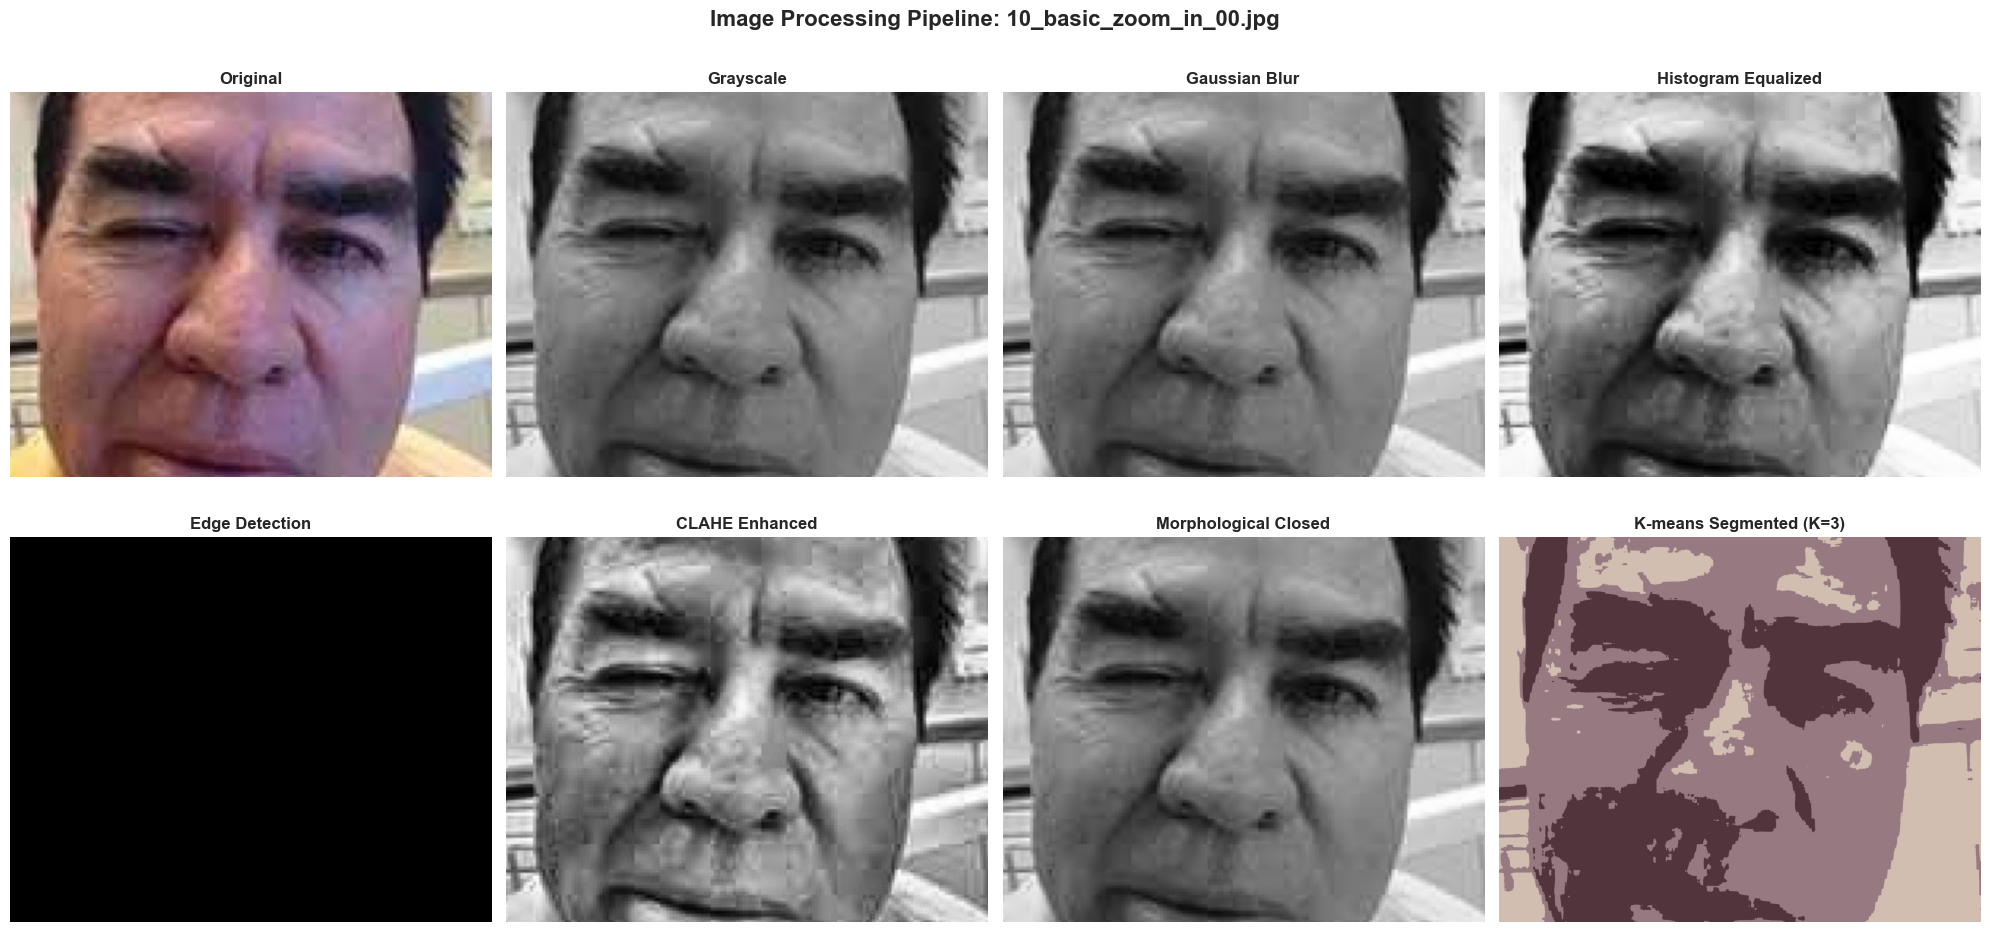


Image Statistics for 10_basic_zoom_in_00.jpg:
Original shape: (4000, 5000, 3)
Grayscale mean intensity: 121.26
Edge density: 0.0000
--------------------------------------------------


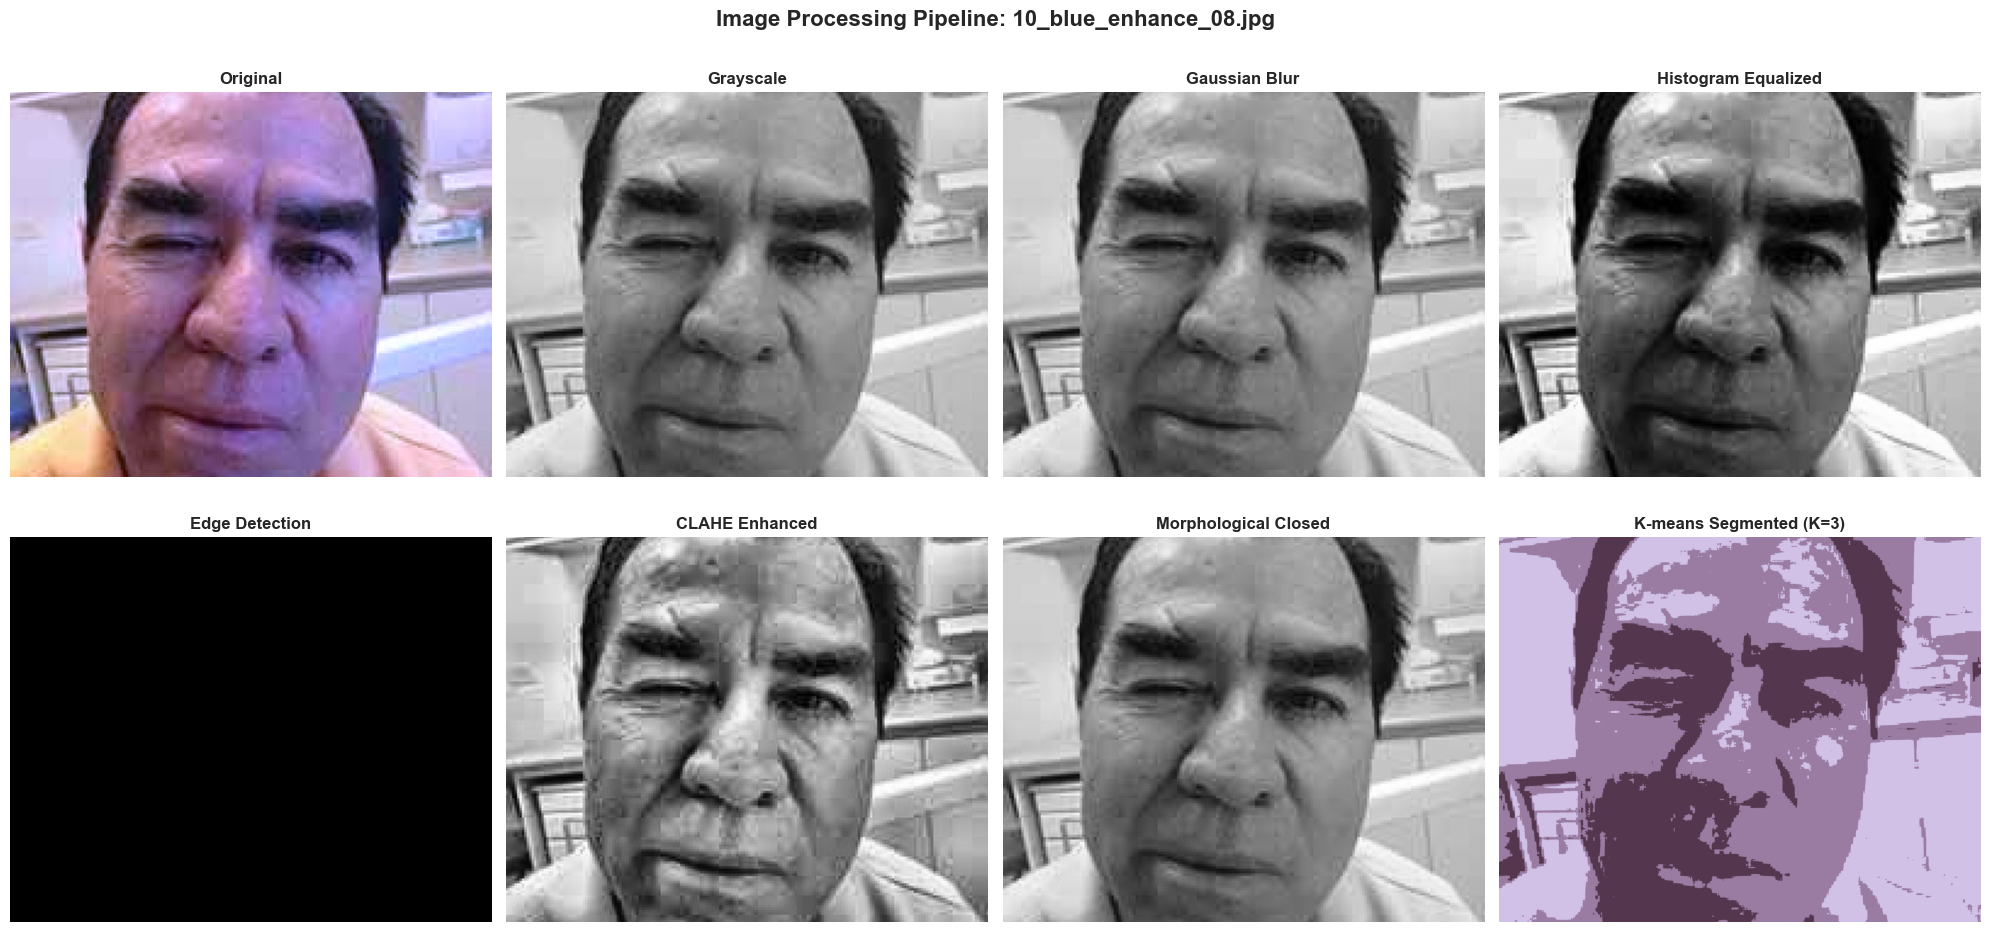


Image Statistics for 10_blue_enhance_08.jpg:
Original shape: (4000, 5000, 3)
Grayscale mean intensity: 142.07
Edge density: 0.0000
--------------------------------------------------


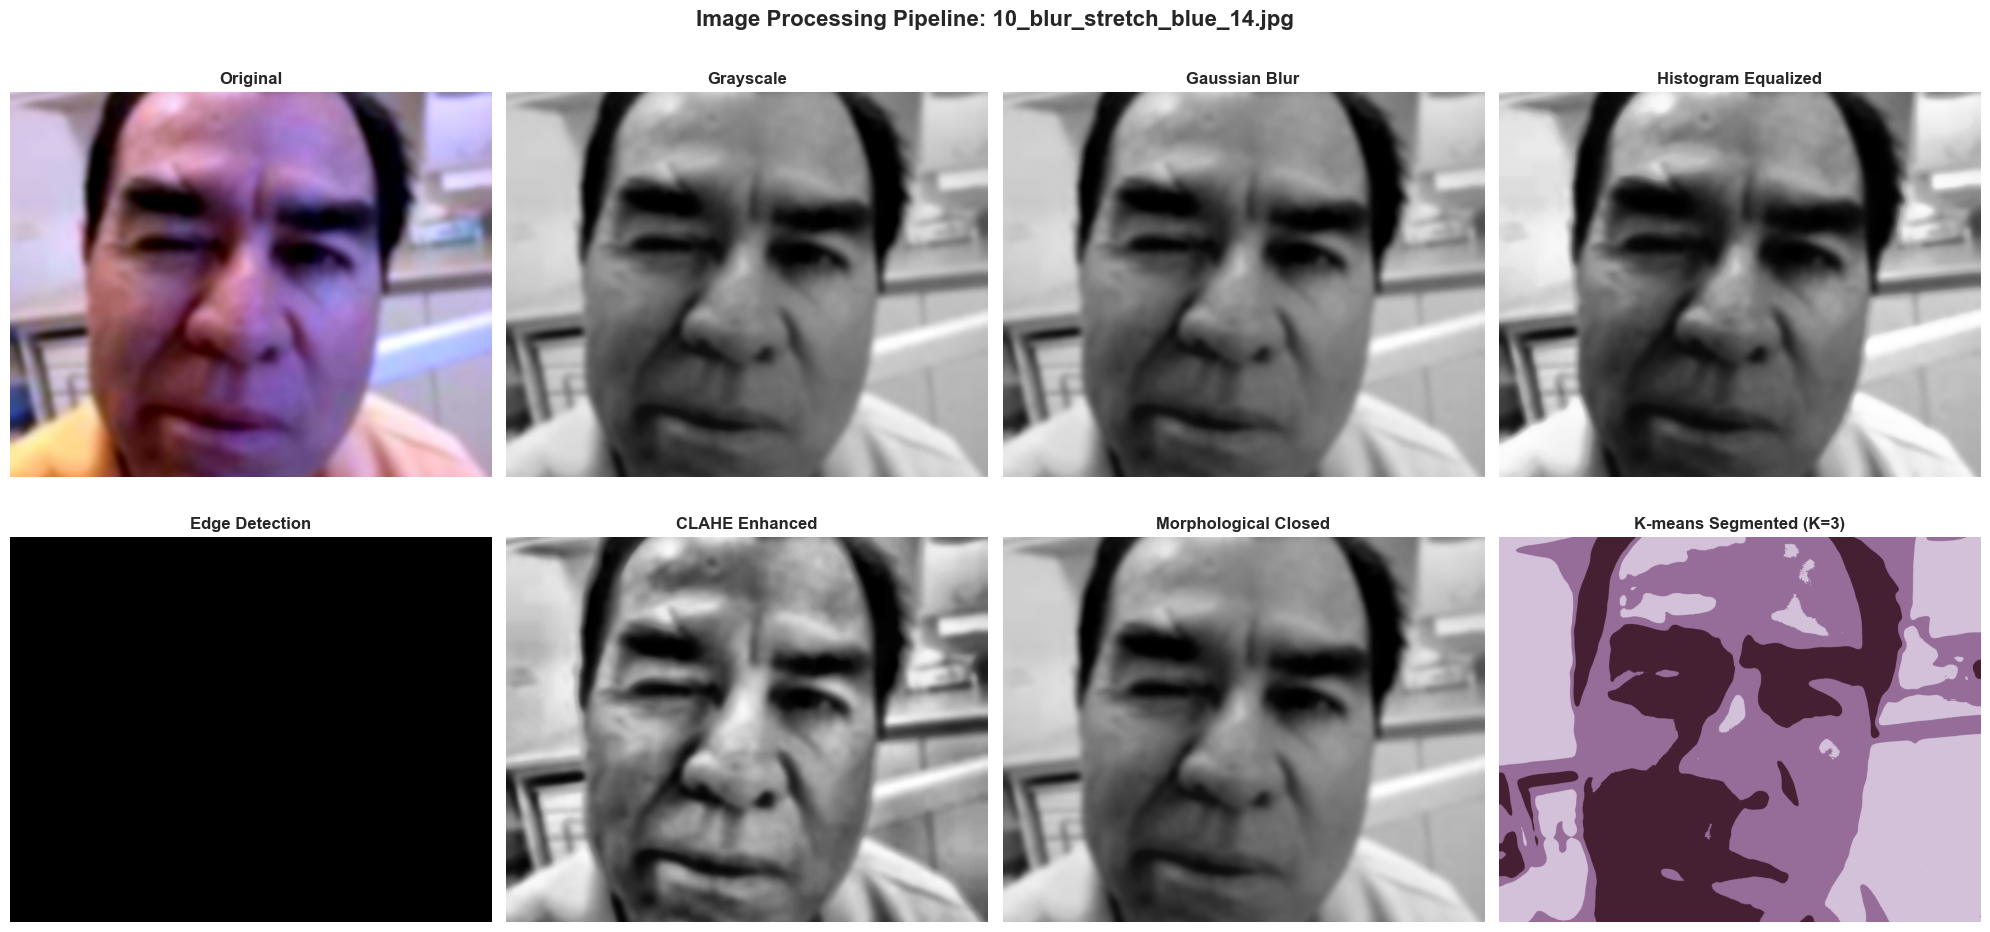


Image Statistics for 10_blur_stretch_blue_14.jpg:
Original shape: (4000, 5000, 3)
Grayscale mean intensity: 127.18
Edge density: 0.0000
--------------------------------------------------

Analyzing processing results...
PROCESSING ANALYSIS REPORT
Total images processed: 5
Average grayscale intensity: 130.36
Average edge density: 0.0000


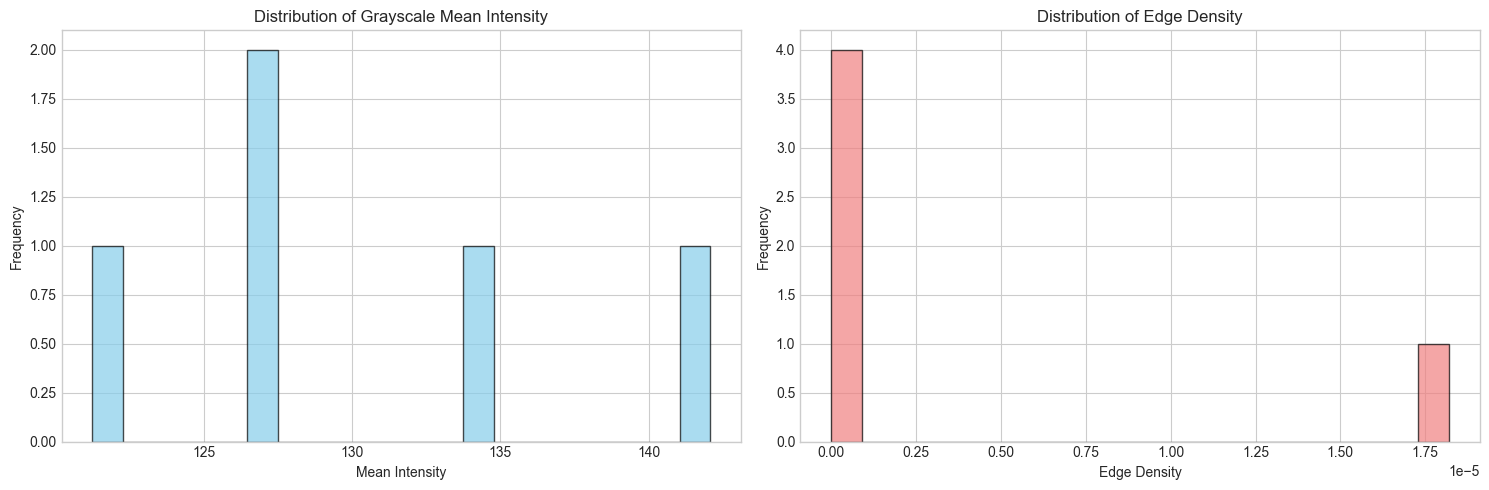

In [ ]:
def display_processing_results(image_path, max_display=5):
    """Display original and processed images for comparison"""
    images_to_display = image_files[:max_display]
    
    for i, img_path in enumerate(images_to_display):
        try:
            # Load and process image
            img = processor.load_image(img_path)
            if img is None:
                continue
                
            # Apply processing
            gray, blurred, equalized = processor.basic_preprocessing(img)
            edges, clahe_img, morph_closed = processor.advanced_processing(img)
            segmented = processor.kmeans_segmentation(img, k=3)
            
            # Create subplot
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            fig.suptitle(f'Image Processing Pipeline: {os.path.basename(img_path)}', fontsize=16, fontweight='bold')
            
            # Display images
            images = [
                (img, 'Original'),
                (gray, 'Grayscale'),
                (blurred, 'Gaussian Blur'),
                (equalized, 'Histogram Equalized'),
                (edges, 'Edge Detection'),
                (clahe_img, 'CLAHE Enhanced'),
                (morph_closed, 'Morphological Closed'),
                (segmented, 'K-means Segmented (K=3)')
            ]
            
            for idx, (image, title) in enumerate(images):
                ax = axes[idx//4, idx%4]
                if len(image.shape) == 2:  # Grayscale
                    ax.imshow(image, cmap='gray')
                else:  # Color
                    ax.imshow(image)
                ax.set_title(title, fontweight='bold')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Print image statistics
            print(f"\nImage Statistics for {os.path.basename(img_path)}:")
            print(f"Original shape: {img.shape}")
            print(f"Grayscale mean intensity: {np.mean(gray):.2f}")
            print(f"Edge density: {np.sum(edges > 0) / edges.size:.4f}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error displaying {img_path}: {str(e)}")
            continue

def analyze_processing_results():
    """Analyze and display processing statistics"""
    try:
        results_df = pd.read_csv(os.path.join(config.analysis_path, "processing_results.csv"))
        
        print("PROCESSING ANALYSIS REPORT")
        print("=" * 50)
        print(f"Total images processed: {len(results_df)}")
        print(f"Average grayscale intensity: {results_df['grayscale_mean'].mean():.2f}")
        print(f"Average edge density: {results_df['edges_density'].mean():.4f}")
        
        # Create summary plots
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Grayscale intensity distribution
        axes[0].hist(results_df['grayscale_mean'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].set_title('Distribution of Grayscale Mean Intensity')
        axes[0].set_xlabel('Mean Intensity')
        axes[0].set_ylabel('Frequency')
        
        # Edge density distribution
        axes[1].hist(results_df['edges_density'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1].set_title('Distribution of Edge Density')
        axes[1].set_xlabel('Edge Density')
        axes[1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        return results_df
        
    except FileNotFoundError:
        print("No processing results found. Please run processing first.")
        return None

# Display results for first few images
print("Displaying processing results for first few images...")
display_processing_results(image_files[0], max_display=3)

# Analyze results
print("\nAnalyzing processing results...")
analysis_results = analyze_processing_results()

#### Frequency Domain Filters (High Pass & Low Pass)

Frequency Domain Filters...


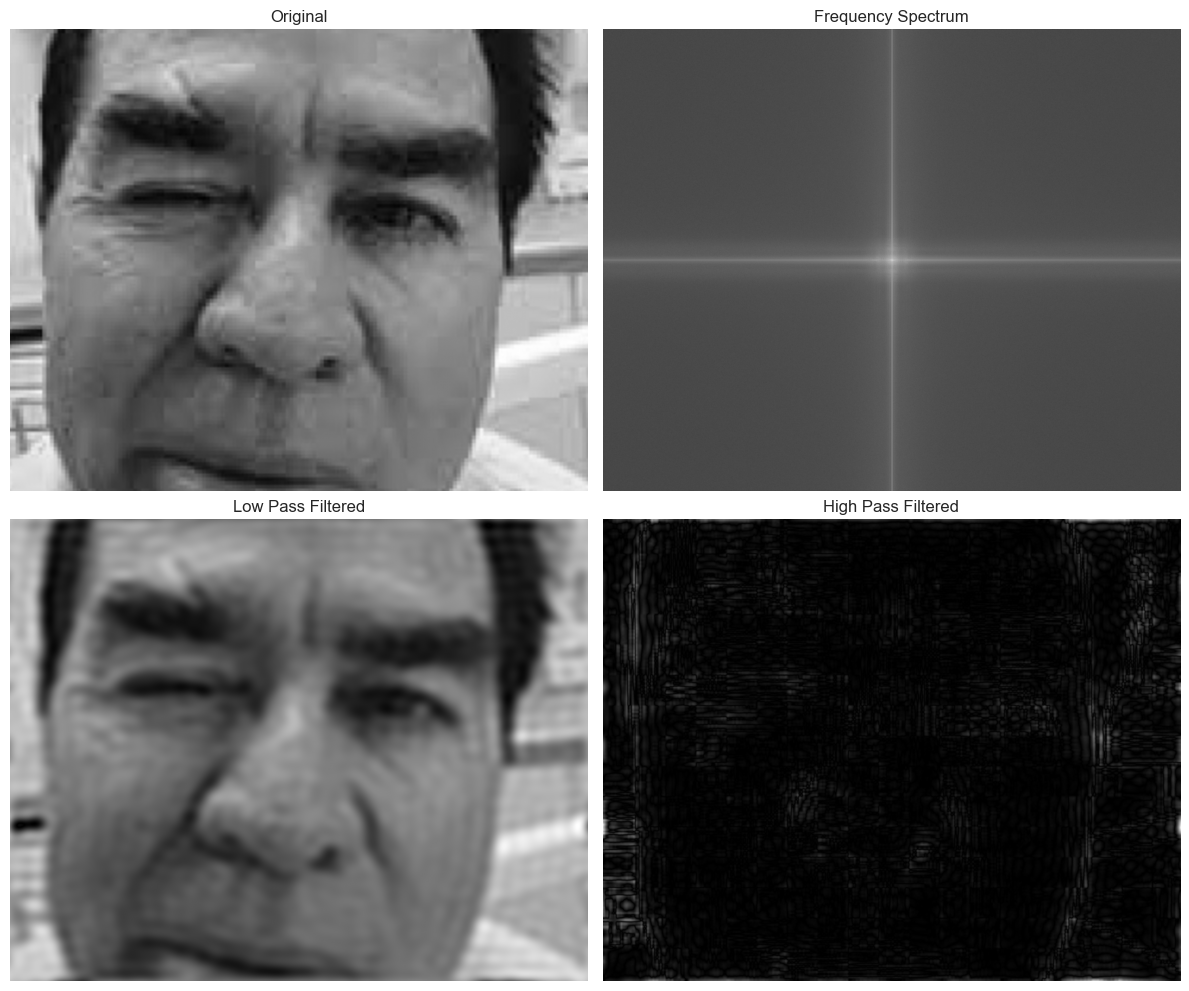

In [ ]:
print("Frequency Domain Filters...")

# Load a sample image for demonstration
sample_img = processor.load_image(image_files[0])
if sample_img is not None:
    gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
    
    # Convert to float32 for DFT
    dft = cv2.dft(np.float32(gray_img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Create Low Pass Filter
    rows, cols = gray_img.shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols, 2), np.uint8)
    r = 30  # radius
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
    mask[mask_area] = 1

    # Apply Low Pass Filter
    fshift_low = dft_shift * mask
    f_ishift_low = np.fft.ifftshift(fshift_low)
    img_back_low = cv2.idft(f_ishift_low)
    img_back_low = cv2.magnitude(img_back_low[:,:,0], img_back_low[:,:,1])

    # Create High Pass Filter
    mask_high = np.ones((rows, cols, 2), np.uint8)
    mask_high[mask_area] = 0

    # Apply High Pass Filter
    fshift_high = dft_shift * mask_high
    f_ishift_high = np.fft.ifftshift(fshift_high)
    img_back_high = cv2.idft(f_ishift_high)
    img_back_high = cv2.magnitude(img_back_high[:,:,0], img_back_high[:,:,1])

    # Display results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0,0].imshow(gray_img, cmap='gray')
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(np.log(1 + cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])), cmap='gray')
    axes[0,1].set_title('Frequency Spectrum')
    axes[0,1].axis('off')

    axes[1,0].imshow(img_back_low, cmap='gray')
    axes[1,0].set_title('Low Pass Filtered')
    axes[1,0].axis('off')

    axes[1,1].imshow(img_back_high, cmap='gray')
    axes[1,1].set_title('High Pass Filtered')
    axes[1,1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for frequency domain analysis")

#### Image Smoothing Techniques

Image Smoothing Techniques...


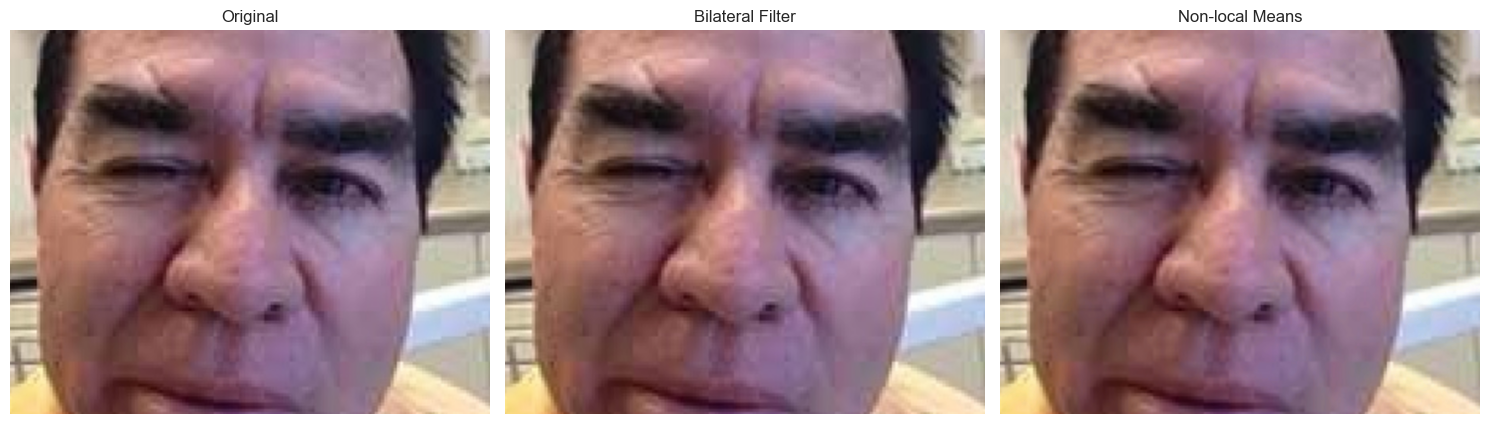

In [ ]:
print("Image Smoothing Techniques...")

# Load sample image if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0])

if sample_img is not None:
    # Bilateral Filter (edge-preserving)
    bilateral_filtered = cv2.bilateralFilter(sample_img, 9, 75, 75)

    # Non-local Means Denoising
    nl_means = cv2.fastNlMeansDenoisingColored(sample_img, None, 10, 10, 7, 21)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(sample_img)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(bilateral_filtered)
    axes[1].set_title('Bilateral Filter')
    axes[1].axis('off')

    axes[2].imshow(nl_means)
    axes[2].set_title('Non-local Means')
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for smoothing techniques")

#### Image Segmentation Techniques

Image Segmentation Techniques...


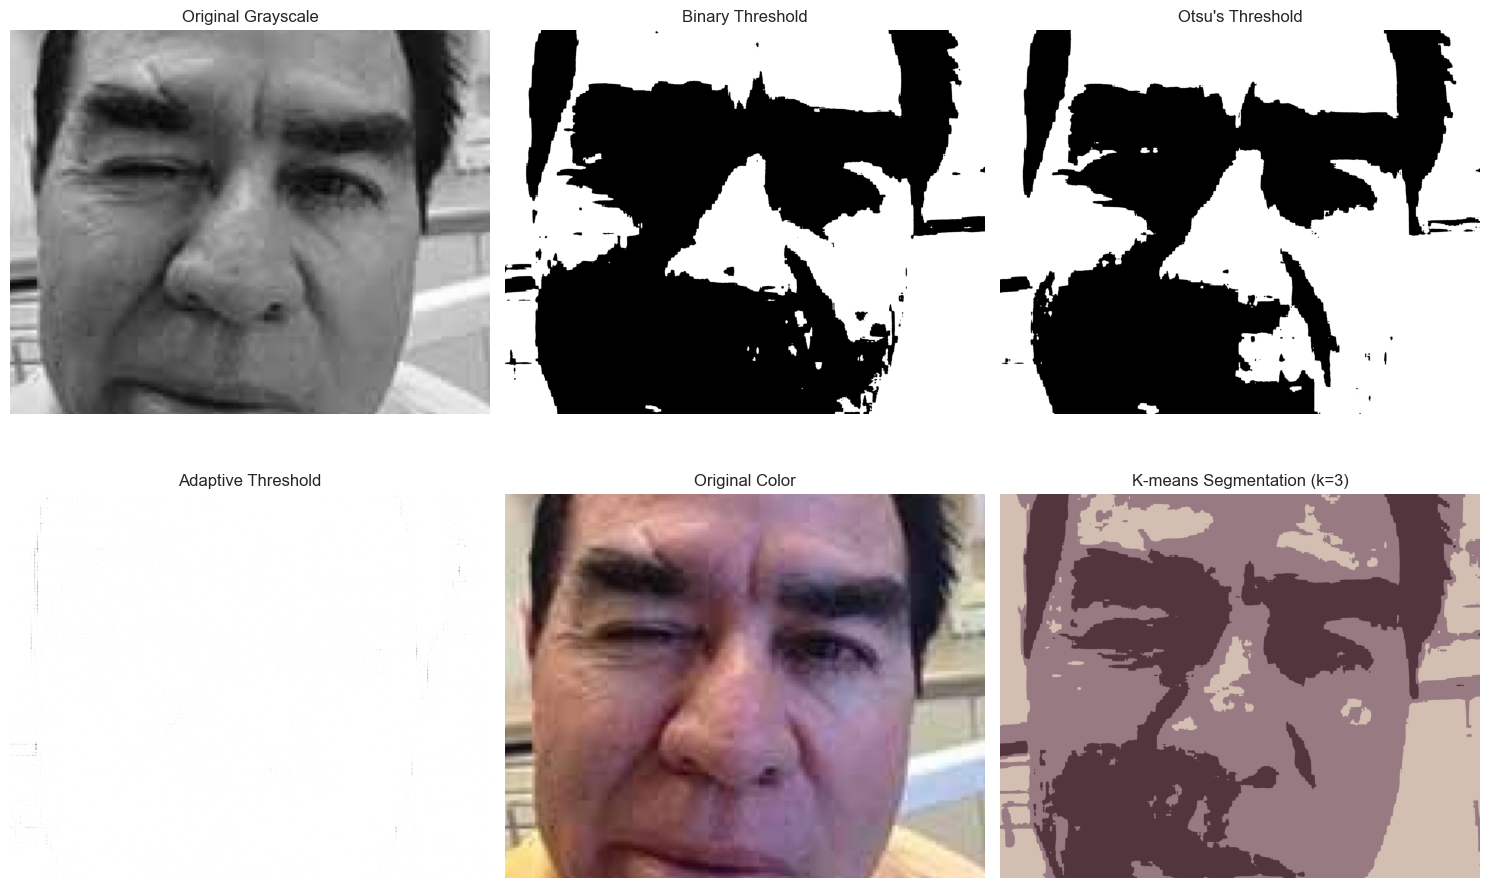

In [ ]:
print("Image Segmentation Techniques...")

# Load sample images if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0])
if sample_img is not None and 'gray_img' not in locals():
    gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

if sample_img is not None and gray_img is not None:
    # 1. Thresholding
    _, binary_thresh = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

    # 2. Otsu's Thresholding
    _, otsu_thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Adaptive Thresholding
    adaptive_thresh = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)

    # 4. K-means Clustering for segmentation
    def kmeans_segmentation(img, k=3):
        """Apply K-means clustering for image segmentation"""
        data = img.reshape((-1, 3))
        data = np.float32(data)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
        _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        
        centers = np.uint8(centers)
        segmented = centers[labels.flatten()]
        return segmented.reshape(img.shape)

    kmeans_segmented = kmeans_segmentation(sample_img)

    # Display segmentation results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0,0].imshow(gray_img, cmap='gray')
    axes[0,0].set_title('Original Grayscale')
    axes[0,0].axis('off')

    axes[0,1].imshow(binary_thresh, cmap='gray')
    axes[0,1].set_title('Binary Threshold')
    axes[0,1].axis('off')

    axes[0,2].imshow(otsu_thresh, cmap='gray')
    axes[0,2].set_title("Otsu's Threshold")
    axes[0,2].axis('off')

    axes[1,0].imshow(adaptive_thresh, cmap='gray')
    axes[1,0].set_title('Adaptive Threshold')
    axes[1,0].axis('off')

    axes[1,1].imshow(sample_img)
    axes[1,1].set_title('Original Color')
    axes[1,1].axis('off')

    axes[1,2].imshow(kmeans_segmented)
    axes[1,2].set_title('K-means Segmentation (k=3)')
    axes[1,2].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for segmentation techniques")

#### Data Preprocessing Pipeline

Data Preprocessing Pipeline...


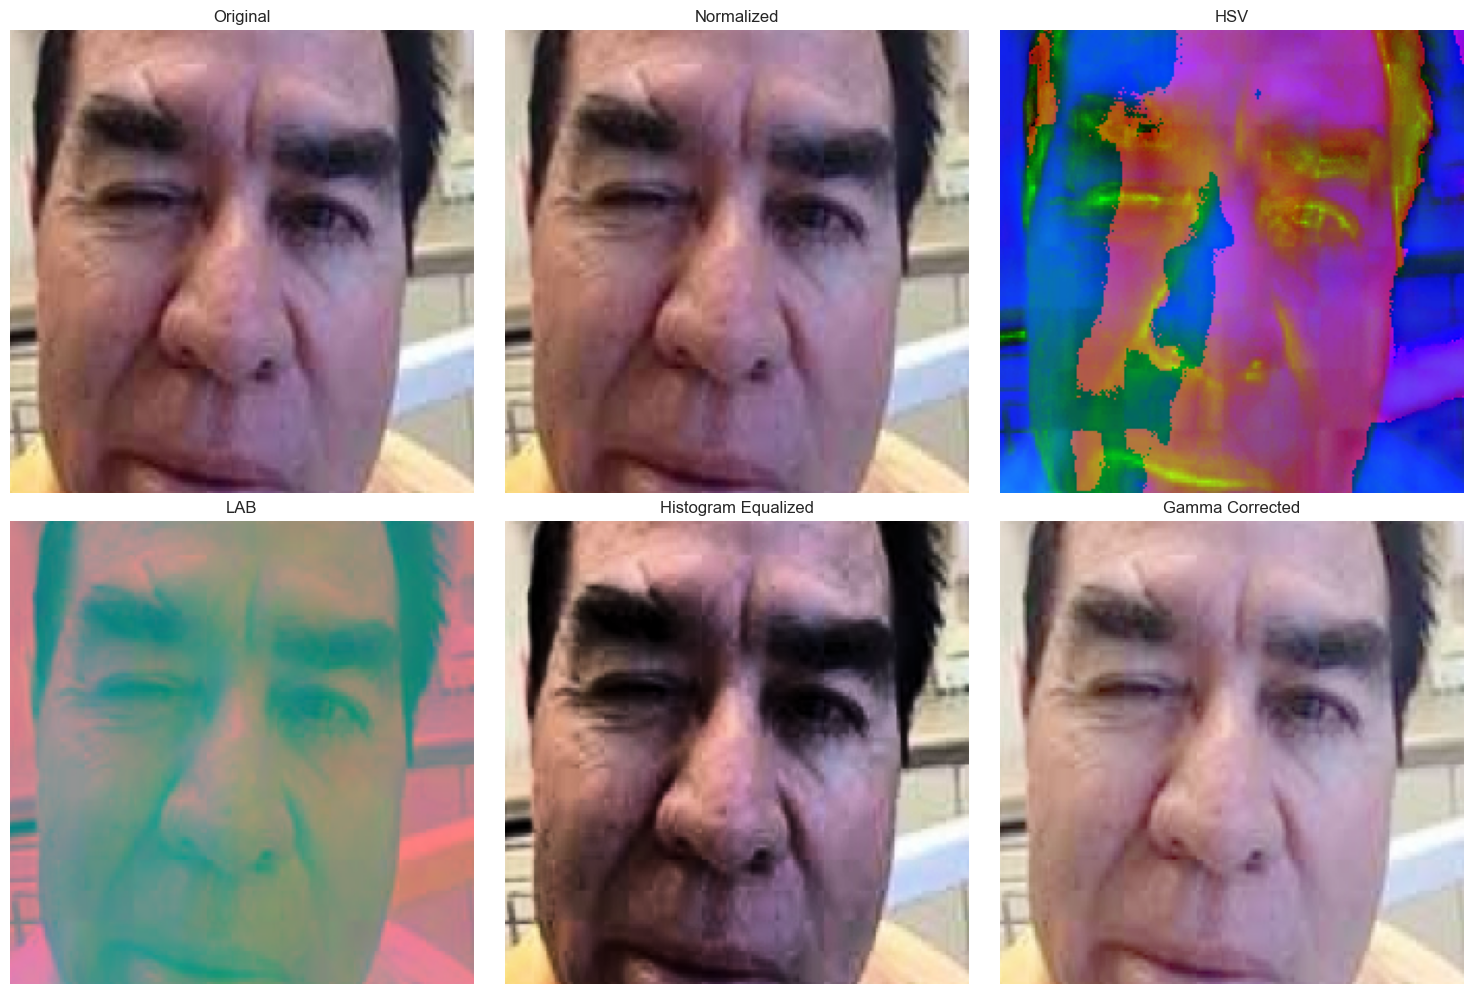

In [ ]:
print("Data Preprocessing Pipeline...")

def preprocess_image(img, target_size=(224, 224)):
    """Complete preprocessing pipeline"""
    # 1. Resize
    resized = cv2.resize(img, target_size)
    
    # 2. Normalize pixel values
    normalized = resized / 255.0
    
    # 3. Convert to different color spaces
    hsv = cv2.cvtColor(resized, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(resized, cv2.COLOR_RGB2LAB)
    
    # 4. Histogram Equalization (on value channel of HSV)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    equalized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    # 5. Gamma correction
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected = cv2.LUT(resized, table)
    
    return {
        'original': resized,
        'normalized': normalized,
        'hsv': hsv,
        'lab': lab,
        'equalized': equalized,
        'gamma_corrected': gamma_corrected
    }

# Load sample image if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0])

if sample_img is not None:
    # Apply preprocessing to sample image
    processed = preprocess_image(sample_img)

    # Display preprocessing results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    titles = ['Original', 'Normalized', 'HSV', 'LAB', 'Histogram Equalized', 'Gamma Corrected']
    images = [processed['original'], processed['normalized'], processed['hsv'], 
              processed['lab'], processed['equalized'], processed['gamma_corrected']]

    for i, (ax, img, title) in enumerate(zip(axes.flat, images, titles)):
        if i == 1:  # Normalized image
            ax.imshow(img)
        elif i in [2, 3]:  # HSV and LAB
            ax.imshow(img)
        else:
            ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for preprocessing pipeline")

#### Edge Detection Methods

Edge Detection Methods...


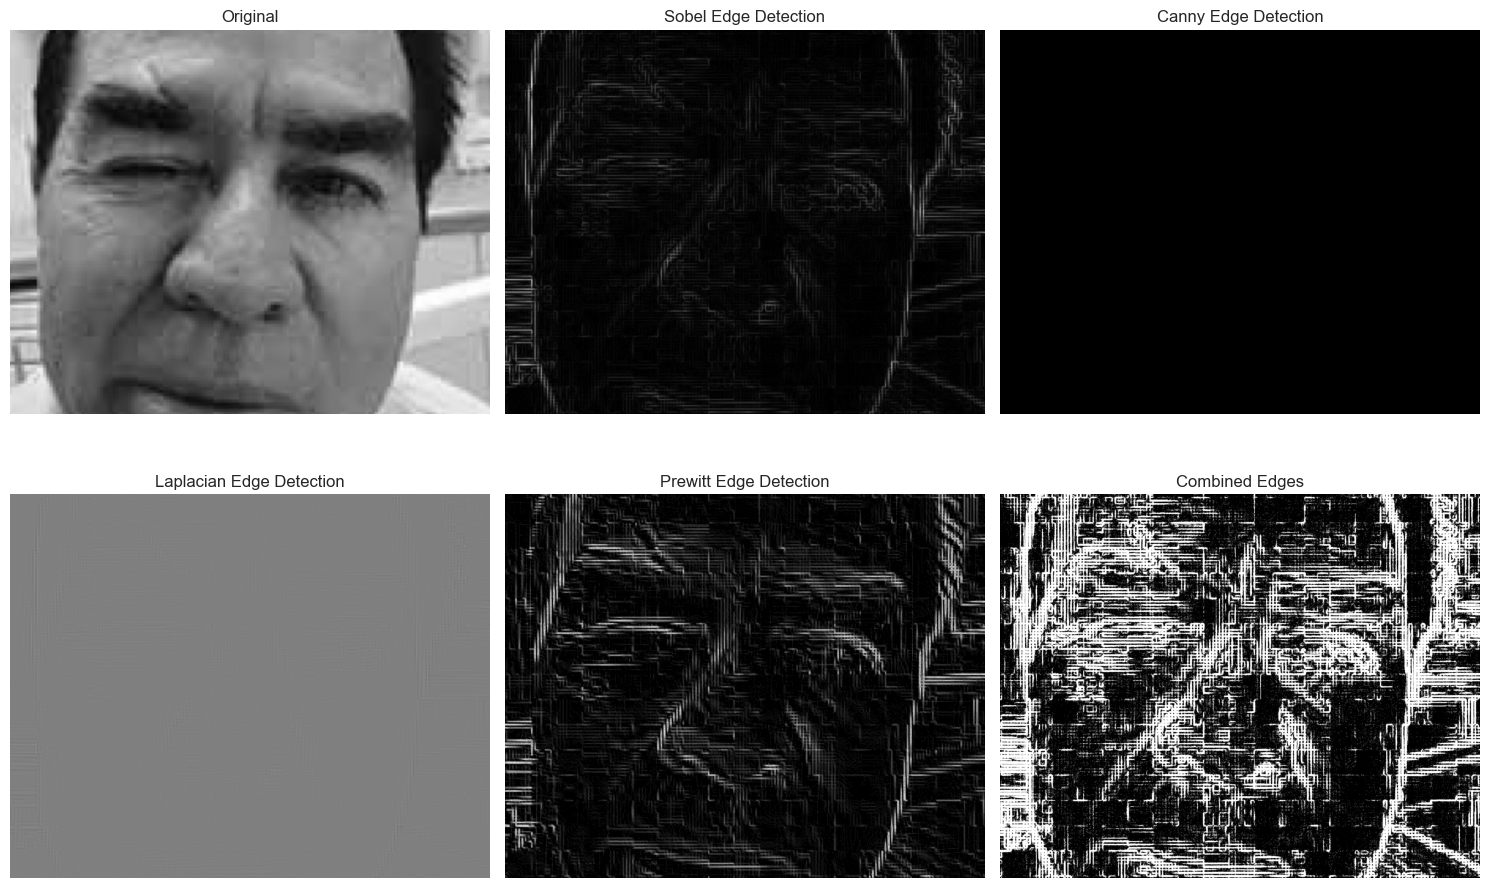

In [ ]:
print("Edge Detection Methods...")

# Load sample images if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0])
if sample_img is not None and 'gray_img' not in locals():
    gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

if sample_img is not None and gray_img is not None:
    # 1. Sobel Edge Detection
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)

    # 2. Canny Edge Detection
    canny_edges = cv2.Canny(gray_img, 100, 200)

    # 3. Laplacian Edge Detection
    laplacian = cv2.Laplacian(gray_img, cv2.CV_64F)

    # 4. Prewitt Edge Detection
    kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    prewittx = cv2.filter2D(gray_img, -1, kernelx)
    prewitty = cv2.filter2D(gray_img, -1, kernely)
    prewitt_combined = np.sqrt(prewittx**2 + prewitty**2)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0,0].imshow(gray_img, cmap='gray')
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(sobel_combined, cmap='gray')
    axes[0,1].set_title('Sobel Edge Detection')
    axes[0,1].axis('off')

    axes[0,2].imshow(canny_edges, cmap='gray')
    axes[0,2].set_title('Canny Edge Detection')
    axes[0,2].axis('off')

    axes[1,0].imshow(laplacian, cmap='gray')
    axes[1,0].set_title('Laplacian Edge Detection')
    axes[1,0].axis('off')

    axes[1,1].imshow(prewitt_combined, cmap='gray')
    axes[1,1].set_title('Prewitt Edge Detection')
    axes[1,1].axis('off')

    # Combined edges for facial analysis
    combined_edges = cv2.bitwise_or(canny_edges, (sobel_combined > 50).astype(np.uint8) * 255)
    axes[1,2].imshow(combined_edges, cmap='gray')
    axes[1,2].set_title('Combined Edges')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for edge detection")

#### Matrix Operations for Image Processing

Matrix Operations for Image Processing...
Image Matrix Shape: (4000, 5000)
Matrix Data Type: uint8


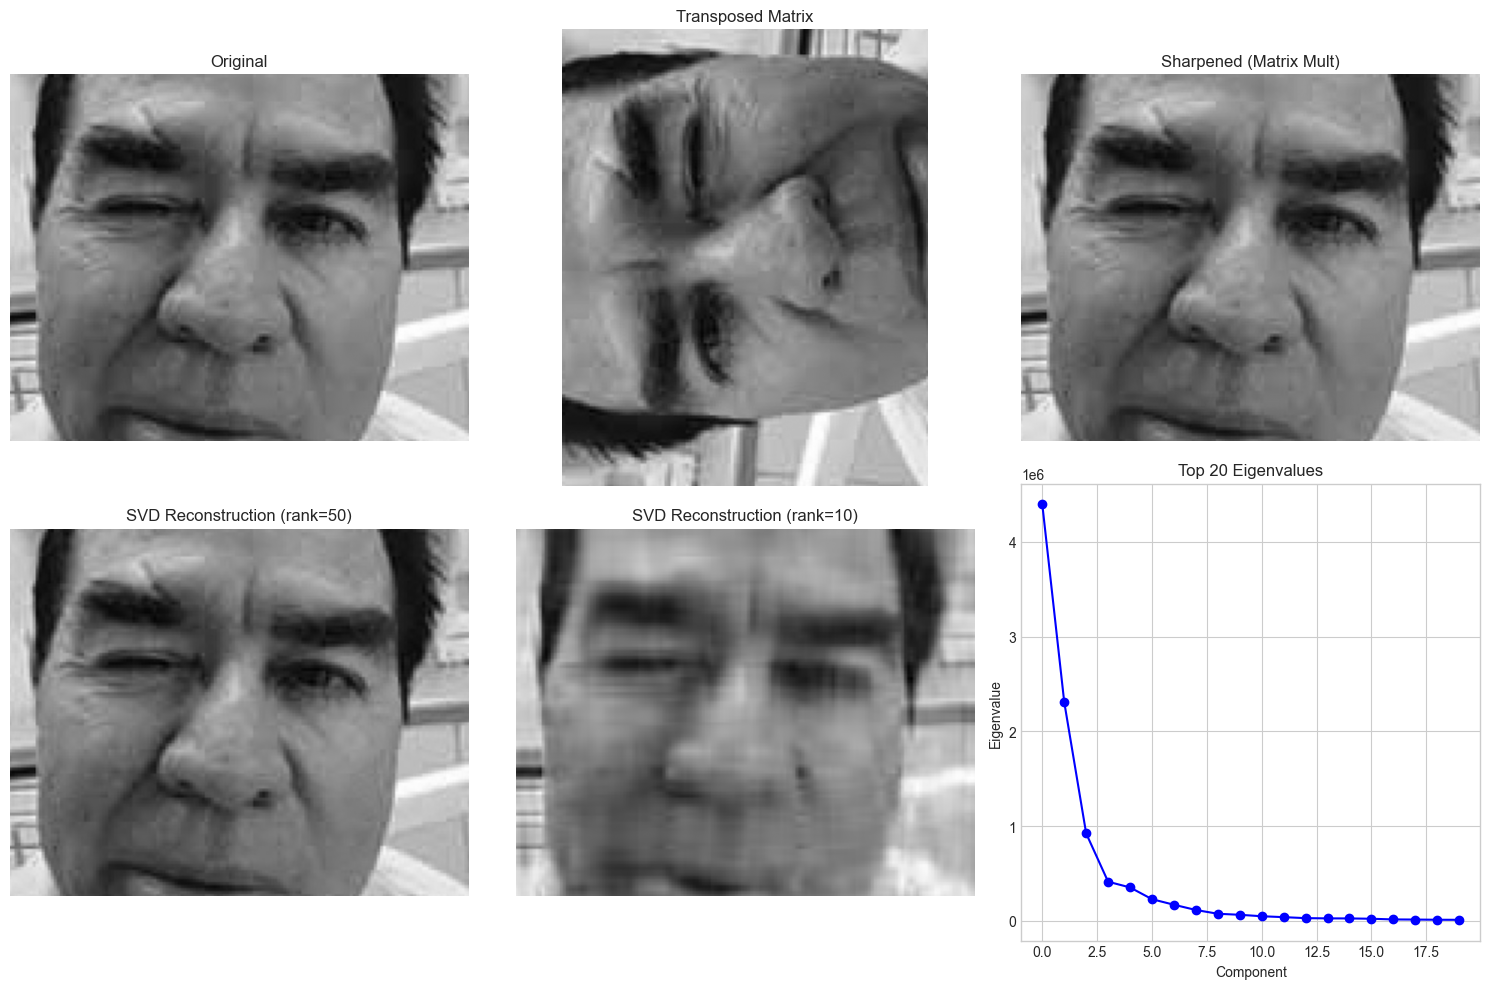

In [ ]:
print("Matrix Operations for Image Processing...")

# Load sample images if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0])
if sample_img is not None and 'gray_img' not in locals():
    gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

if sample_img is not None and gray_img is not None:
    # Convert image to matrix
    img_matrix = np.array(gray_img)
    print(f"Image Matrix Shape: {img_matrix.shape}")
    print(f"Matrix Data Type: {img_matrix.dtype}")

    # Matrix operations
    # 1. Matrix transpose
    transposed = img_matrix.T

    # 2. Matrix multiplication (with a filter kernel)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(gray_img, -1, kernel)

    # 3. Eigenvalues and eigenvectors for PCA
    cov_matrix = np.cov(img_matrix.astype(float))
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # 4. Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(img_matrix.astype(float), full_matrices=False)

    # Reconstruct image with different ranks
    rank_50 = np.dot(U[:, :50], np.dot(np.diag(S[:50]), Vt[:50, :]))
    rank_10 = np.dot(U[:, :10], np.dot(np.diag(S[:10]), Vt[:10, :]))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0,0].imshow(gray_img, cmap='gray')
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(transposed, cmap='gray')
    axes[0,1].set_title('Transposed Matrix')
    axes[0,1].axis('off')

    axes[0,2].imshow(sharpened, cmap='gray')
    axes[0,2].set_title('Sharpened (Matrix Mult)')
    axes[0,2].axis('off')

    axes[1,0].imshow(rank_50, cmap='gray')
    axes[1,0].set_title('SVD Reconstruction (rank=50)')
    axes[1,0].axis('off')

    axes[1,1].imshow(rank_10, cmap='gray')
    axes[1,1].set_title('SVD Reconstruction (rank=10)')
    axes[1,1].axis('off')

    # Plot eigenvalues
    axes[1,2].plot(np.sort(eigenvalues)[::-1][:20], 'bo-')
    axes[1,2].set_title('Top 20 Eigenvalues')
    axes[1,2].set_xlabel('Component')
    axes[1,2].set_ylabel('Eigenvalue')

    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for matrix operations")

#### Morphological Operations

Morphological Operations...


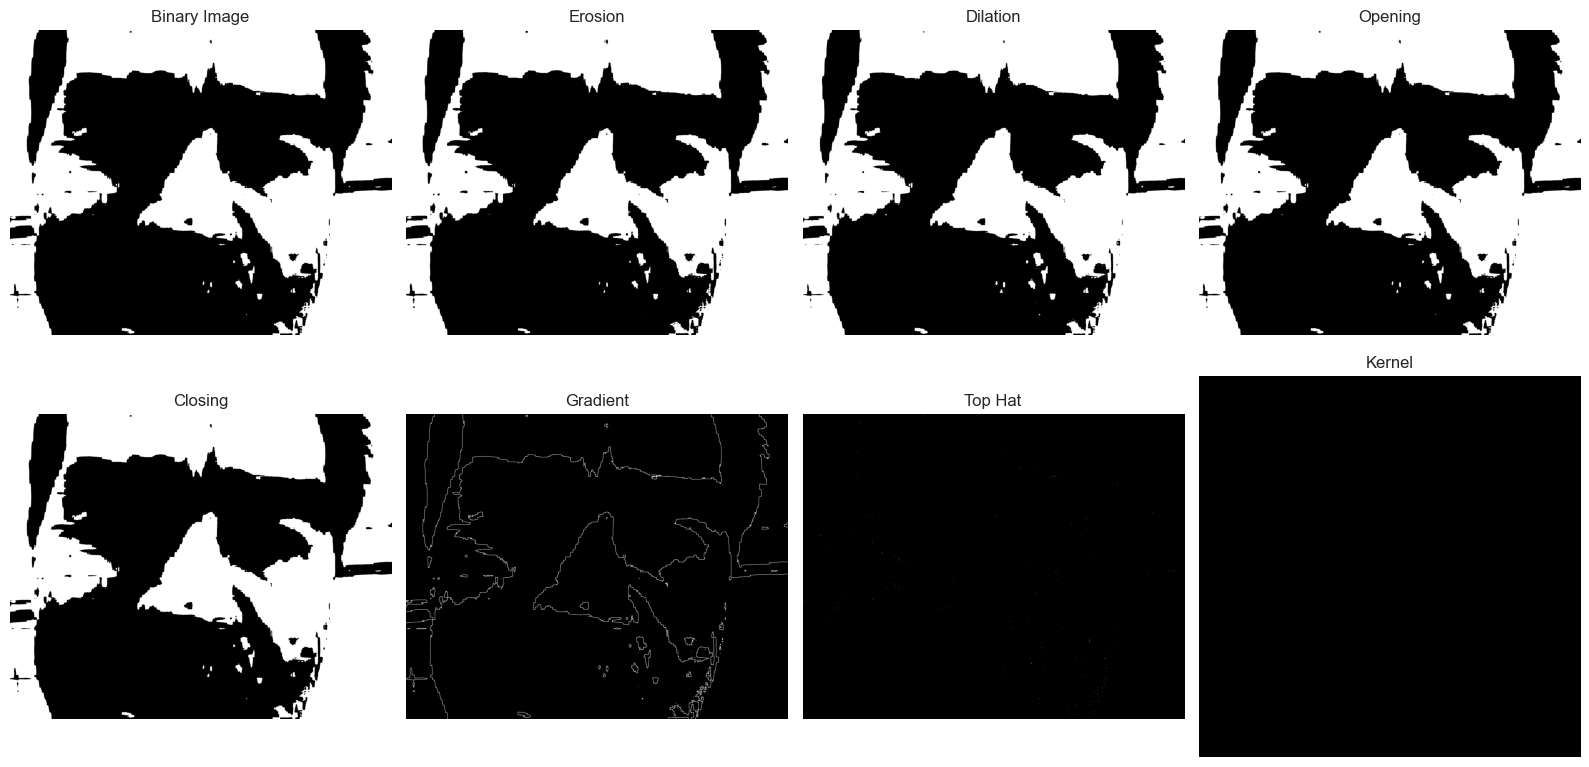

In [ ]:
print("Morphological Operations...")

# Load sample images if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0])
if sample_img is not None and 'gray_img' not in locals():
    gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

if sample_img is not None and gray_img is not None:
    # Create a binary image for morphological operations
    _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

    # Define kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

    # Erosion
    erosion = cv2.erode(binary_img, kernel, iterations=1)

    # Dilation
    dilation = cv2.dilate(binary_img, kernel, iterations=1)

    # Opening (erosion followed by dilation)
    opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

    # Closing (dilation followed by erosion)
    closing = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Gradient (difference between dilation and erosion)
    gradient = cv2.morphologyEx(binary_img, cv2.MORPH_GRADIENT, kernel)

    # Top Hat (difference between input and opening)
    tophat = cv2.morphologyEx(binary_img, cv2.MORPH_TOPHAT, kernel)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    operations = [binary_img, erosion, dilation, opening, 
                 closing, gradient, tophat, kernel*255]
    titles = ['Binary Image', 'Erosion', 'Dilation', 'Opening', 
              'Closing', 'Gradient', 'Top Hat', 'Kernel']

    for i, (ax, img, title) in enumerate(zip(axes.flat, operations, titles)):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for morphological operations")

In [ ]:
print("Batch Processing Entire Dataset...")

def process_hemifacial_dataset():
    """Process all images in the hemifacial spasm dataset"""
    results = []
    
    for img_path in image_files[:min(5, len(image_files))]:  # Process first 5 images as example
        try:
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Apply processing pipeline
            gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
            
            # Denoising
            denoised = cv2.medianBlur(gray, 3)
            
            # Edge detection
            edges = cv2.Canny(denoised, 50, 150)
            
            # Feature extraction
            mean_intensity = np.mean(gray)
            edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
            
            results.append({
                'filename': os.path.basename(img_path),
                'original_shape': img.shape,
                'mean_intensity': mean_intensity,
                'edge_density': edge_density,
                'processed_edges': edges
            })
            
            print(f"Processed: {os.path.basename(img_path)}")
            
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
    
    return results

# Process dataset
if image_files:
    dataset_results = process_hemifacial_dataset()

    # Display summary
    if dataset_results:
        print("\nDataset Processing Summary:")
        for result in dataset_results:
            print(f"File: {result['filename']}")
            print(f"  Shape: {result['original_shape']}")
            print(f"  Mean Intensity: {result['mean_intensity']:.2f}")
            print(f"  Edge Density: {result['edge_density']:.4f}")
            print()
else:
    print("No images found in dataset for batch processing")

Batch Processing Entire Dataset...
Processed: 10_basic_zoom_in_00.jpg
Processed: 10_blue_enhance_08.jpg
Processed: 10_blur_stretch_blue_14.jpg
Processed: 10_contrast_enhance_11.jpg
Processed: 10_contrast_stretch_13.jpg

Dataset Processing Summary:
File: 10_basic_zoom_in_00.jpg
  Shape: (4000, 5000, 3)
  Mean Intensity: 121.26
  Edge Density: 0.0000

File: 10_blue_enhance_08.jpg
  Shape: (4000, 5000, 3)
  Mean Intensity: 142.07
  Edge Density: 0.0000

File: 10_blur_stretch_blue_14.jpg
  Shape: (4000, 5000, 3)
  Mean Intensity: 127.18
  Edge Density: 0.0000

File: 10_contrast_enhance_11.jpg
  Shape: (4000, 5000, 3)
  Mean Intensity: 134.71
  Edge Density: 0.0058

File: 10_contrast_stretch_13.jpg
  Shape: (4000, 5000, 3)
  Mean Intensity: 126.57
  Edge Density: 0.0001



#### Advanced Hemifacial Spasm Analysis

Advanced Hemifacial Spasm Analysis...
Asymmetry Score: 0.1461
Edge Asymmetry: 0.0000


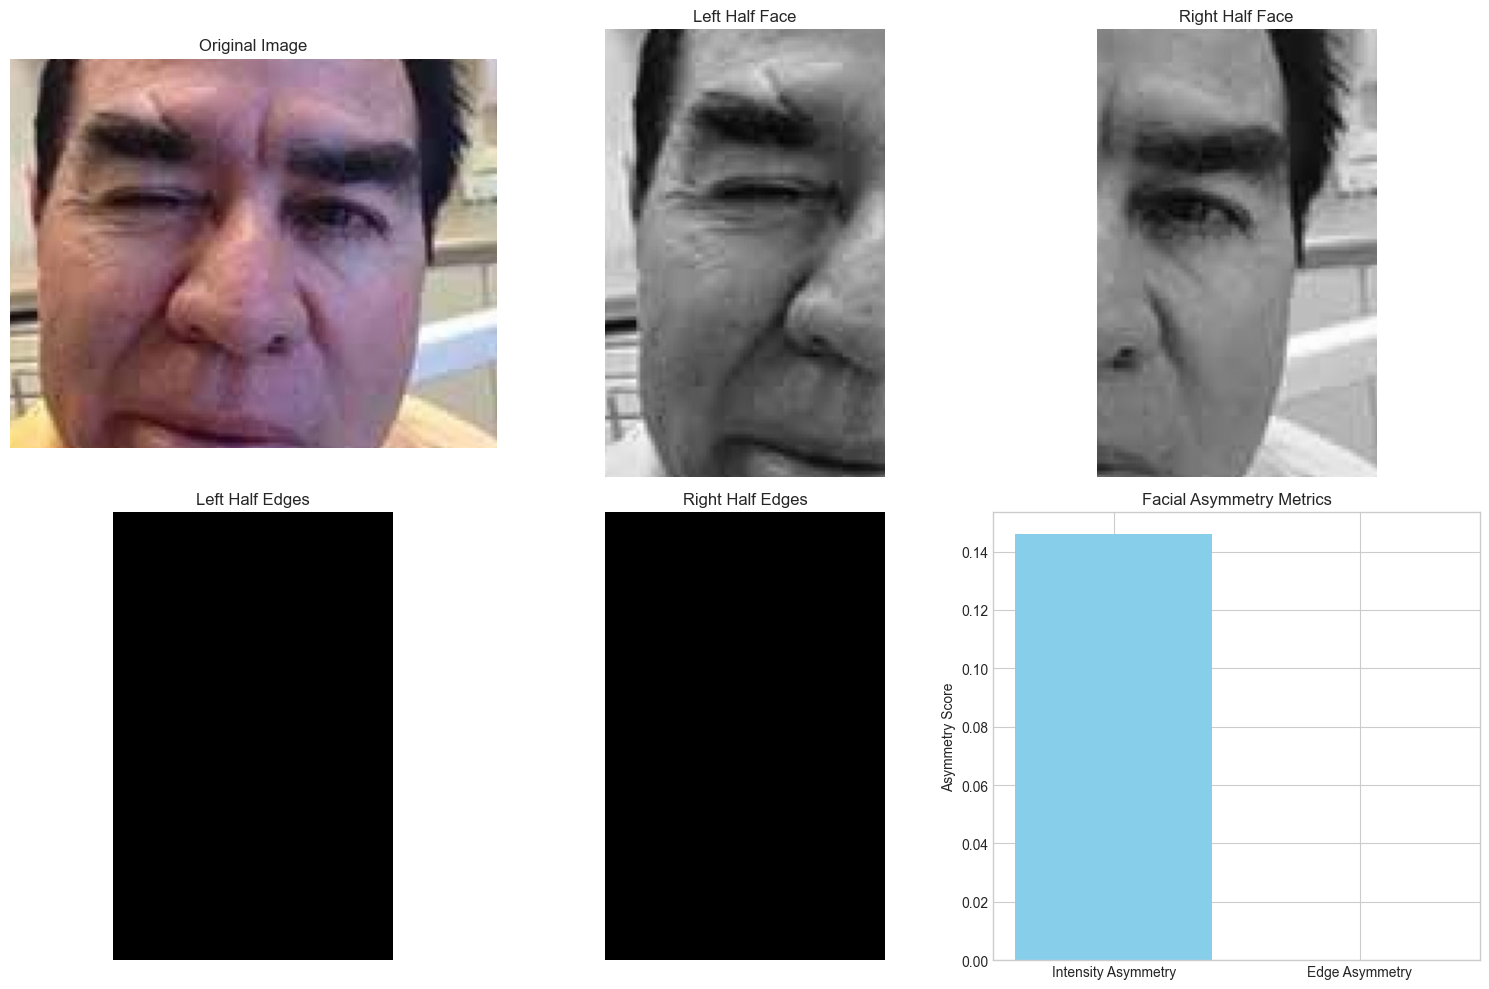

In [ ]:
print("Advanced Hemifacial Spasm Analysis...")

def analyze_facial_asymmetry(img):
    """Analyze facial asymmetry which is important for hemifacial spasm"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Split image into left and right halves
    height, width = gray.shape
    left_half = gray[:, :width//2]
    right_half = gray[:, width//2:]
    
    # Flip right half for comparison
    right_half_flipped = cv2.flip(right_half, 1)
    
    # Calculate asymmetry metrics
    left_mean = np.mean(left_half)
    right_mean = np.mean(right_half)
    asymmetry_score = abs(left_mean - right_mean) / max(left_mean, right_mean)
    
    # Edge density comparison
    left_edges = cv2.Canny(left_half, 50, 150)
    right_edges = cv2.Canny(right_half, 50, 150)
    left_edge_density = np.sum(left_edges) / left_edges.size
    right_edge_density = np.sum(right_edges) / right_edges.size
    edge_asymmetry = abs(left_edge_density - right_edge_density)
    
    return {
        'asymmetry_score': asymmetry_score,
        'edge_asymmetry': edge_asymmetry,
        'left_half': left_half,
        'right_half': right_half,
        'left_edges': left_edges,
        'right_edges': right_edges
    }

# Load sample image if not already loaded
if 'sample_img' not in locals():
    sample_img = processor.load_image(image_files[0]) if image_files else None

if sample_img is not None:
    # Analyze sample image
    asymmetry_analysis = analyze_facial_asymmetry(sample_img)

    print(f"Asymmetry Score: {asymmetry_analysis['asymmetry_score']:.4f}")
    print(f"Edge Asymmetry: {asymmetry_analysis['edge_asymmetry']:.4f}")

    # Display asymmetry analysis
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0,0].imshow(sample_img)
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')

    axes[0,1].imshow(asymmetry_analysis['left_half'], cmap='gray')
    axes[0,1].set_title('Left Half Face')
    axes[0,1].axis('off')

    axes[0,2].imshow(asymmetry_analysis['right_half'], cmap='gray')
    axes[0,2].set_title('Right Half Face')
    axes[0,2].axis('off')

    axes[1,0].imshow(asymmetry_analysis['left_edges'], cmap='gray')
    axes[1,0].set_title('Left Half Edges')
    axes[1,0].axis('off')

    axes[1,1].imshow(asymmetry_analysis['right_edges'], cmap='gray')
    axes[1,1].set_title('Right Half Edges')
    axes[1,1].axis('off')

    # Plot asymmetry metrics
    metrics = ['Intensity Asymmetry', 'Edge Asymmetry']
    values = [asymmetry_analysis['asymmetry_score'], asymmetry_analysis['edge_asymmetry']]
    axes[1,2].bar(metrics, values, color=['skyblue', 'lightcoral'])
    axes[1,2].set_title('Facial Asymmetry Metrics')
    axes[1,2].set_ylabel('Asymmetry Score')

    plt.tight_layout()
    plt.show()
else:
    print("No sample image available for hemifacial spasm analysis")